In [3]:
#imports
import numpy as np 
import math
import matplotlib.pyplot as plt 

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

In [42]:
#affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim, mask, hidden_dim=64, alpha=0.6):
        super().__init__()
        self.mask = mask
        self.alpha = alpha
        self.scale_net = self._build_net(dim, hidden_dim)
        self.trans_net = self._build_net(dim, hidden_dim)
        self.actnorm = ActNorm1d(dim)
        self.beta = nn.Parameter(torch.zeros(dim))

    def _build_net(self, dim, hidden_dim):
        return nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1)
        t = self.trans_net(x1)
        scale = torch.clamp(1 + self.alpha * torch.tanh(s), min=1e-2, max=1.5)
        trans = torch.exp(self.beta) * torch.tanh(t)
        x2 = x * (1 - self.mask)
        x2_out = x2 * scale + trans
        x_out = x1 + x2_out
        log_det = torch.sum(torch.log(scale), dim=1)
        return x_out, log_det

    def inverse(self, x):
        x1 = x * self.mask
        s = self.scale_net(x1)
        t = self.trans_net(x1)
        scale = torch.clamp(1 + self.alpha * torch.tanh(s), min=1e-2, max=1.5)
        trans = torch.exp(self.beta) * torch.tanh(t)
        x2 = (x * (1 - self.mask) - trans) / scale
        x_out = x1 + x2
        log_det = -torch.sum(torch.log(scale), dim=1)
        return x_out, log_det

In [43]:
#kr block (subset of the krnet)
class KRBlock(nn.Module):
    def __init__(self, dim, num_layers=4, mask_fn=None):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            mask = mask_fn(i, dim) if mask_fn else self.default_mask(i, dim)
            self.layers.append(AffineCoupling(dim, mask))

    def default_mask(self, i, dim):
        mask = torch.zeros(dim)
        mask[i % dim] = 1
        return mask

    def forward(self, x):
        log_det = 0
        for layer in self.layers:
            x, ld = layer(x)
            log_det += ld
        return x, log_det

    def inverse(self, x):
        log_det = 0
        for layer in reversed(self.layers):
            x, ld = layer.inverse(x)
            log_det += ld
        return x, log_det

In [44]:
#KRnet implementation
class KRnet(nn.Module):
    def __init__(self, dim, K=3, L=4):
        super().__init__()
        self.blocks = nn.ModuleList()
        for k in range(K):
            self.blocks.append(KRBlock(dim, num_layers=L, mask_fn=self.generate_mask_fn(k)))

    def generate_mask_fn(self, stage):
        def mask_fn(i, dim):
            mask = torch.zeros(dim)
            mask[:dim - stage] = 1
            return mask
        return mask_fn

    def forward(self, x):
        log_det = 0
        for block in self.blocks:
            x, ld = block(x)
            log_det += ld
        return x, log_det

    def inverse(self, z):
        log_det = 0
        for block in reversed(self.blocks):
            z, ld = block.inverse(z)
            log_det += ld
        return z, log_det

In [45]:
#data generation
def generate_2d_pdf_samples(n):
        mean = torch.tensor([[0.0, 0.0]])
        cov = torch.tensor([[0.5, 0.0], [0.0, 0.5]])
        samples = torch.randn(n, 2) @ torch.linalg.cholesky(cov) + mean
        return samples

X = generate_2d_pdf_samples(1000)
dataset = DataLoader(TensorDataset(X), batch_size=128, shuffle=True)

Epoch 1: Avg NLL = 2.7252
  log_prob_z mean: -2.4743
  log_det mean:    0.7197
Epoch 11: Avg NLL = -7.8560
  log_prob_z mean: -1.8395
  log_det mean:    9.7175
Epoch 21: Avg NLL = -7.8883
  log_prob_z mean: -1.8430
  log_det mean:    9.7274
Epoch 31: Avg NLL = -7.8904
  log_prob_z mean: -1.8448
  log_det mean:    9.7308
Epoch 41: Avg NLL = -7.8926
  log_prob_z mean: -1.8383
  log_det mean:    9.7306
Epoch 51: Avg NLL = -7.8923
  log_prob_z mean: -1.8391
  log_det mean:    9.7309
Epoch 61: Avg NLL = -7.8927
  log_prob_z mean: -1.8383
  log_det mean:    9.7312
Epoch 71: Avg NLL = -7.8925
  log_prob_z mean: -1.8380
  log_det mean:    9.7311
Epoch 81: Avg NLL = -7.8919
  log_prob_z mean: -1.8383
  log_det mean:    9.7311
Epoch 91: Avg NLL = -7.8926
  log_prob_z mean: -1.8382
  log_det mean:    9.7311
Reconstruction MSE: 0.874750


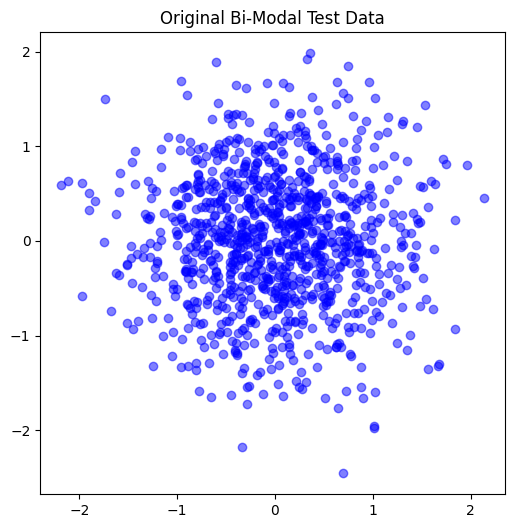

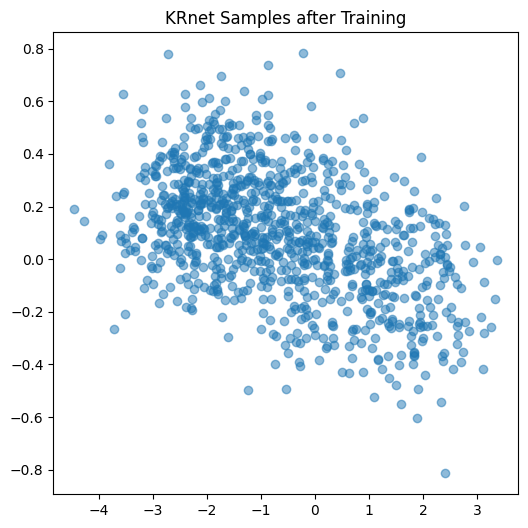

In [46]:
#training loop
model = KRnet(dim=2, K=3, L=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    total_loss = 0
    total_samples = 0
    for batch in dataset:
        x = batch[0]
        z, log_det = model(x)
        log_prob_z = -0.5 * torch.sum(z**2, dim=1) - x.size(1) * 0.5 * torch.log(torch.tensor(2 * torch.pi))
        log_prob = log_prob_z + log_det
        loss = -torch.mean(log_prob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        total_samples += x.size(0)
    if epoch % 10 == 0:
        avg_nll = total_loss / total_samples
        print(f"Epoch {epoch+1}: Avg NLL = {avg_nll:.4f}")
        print(f"  log_prob_z mean: {log_prob_z.mean().item():.4f}")
        print(f"  log_det mean:    {log_det.mean().item():.4f}")

#original data vis
X_np = X.numpy()
plt.figure(figsize=(6, 6))
plt.scatter(X_np[:, 0], X_np[:, 1], alpha=0.5, color='blue')
plt.title("Original Bi-Modal Test Data")
    
#training output vis
with torch.no_grad():
    z = torch.randn(1000, 2)
    x_gen, _ = model.inverse(z)
    x_gen = x_gen.numpy()
    plt.figure(figsize=(6, 6))
    plt.scatter(x_gen[:, 0], x_gen[:, 1], alpha=0.5)
    plt.title("KRnet Samples after Training")
    
    x_sample = generate_2d_pdf_samples(1000)
    z, _ = model(x_sample)
    x_recon, _ = model.inverse(z)
    mse = functional.mse_loss(x_recon, x_sample)
    print(f"Reconstruction MSE: {mse.item():.6f}")